In [1]:
cd /content/drive/My\ Drive/Transformer/

/content/drive/My Drive/Transformer


# ライブラリ読み込み

In [2]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.6
!pip install japanize_matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [3]:
import numpy as np
import os
import time
import MeCab

import preprocess_utils
import model
import weight_utils

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

2.3.0


/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


# 日英翻訳データ ダウンロード

In [ ]:
!wget http://www.manythings.org/anki/jpn-eng.zip
!unzip ./jpn-eng.zip

# データ読み込み

In [4]:
dataset = preprocess_utils.CreateData(
    corpus_path = './jpn.txt',
    do_shuffle=True,
    seed_value=100,
    split_percent=0.95 # 学習データの割合
)

train_source, train_target, test_source, test_target = dataset.split_data()

print('**** Amount of data ****')
print('train_source： ', len(train_source))
print('train_target： ', len(train_target))
print('test_source： ', len(test_source))
print('test_target： ', len(test_target))
print('\n')
print('**** Train data example ****')
print('Source Example： ', train_source[0])
print('Target Example： ', train_target[0])
print('\n')
print('**** Test data example ****')
print('Source Example： ', test_source[0])
print('Target Example： ', test_target[0])

**** Amount of data ****
train_source：  50914
train_target：  50914
test_source：  2680
test_target：  2680


**** Train data example ****
Source Example：  Tom loves spaghetti.
Target Example：  トムはスパゲッティが大好きです。


**** Test data example ****
Source Example：  Being left alone, the boy didn't know what to do.
Target Example：  ひとりぼっちにされて少年はどうしてよいかわからなかった。


# 前処理

In [5]:
BATCH_SIZE = 64 # バッチサイズ
MAX_LANGTH = 60 # シーケンスの長さ
USE_TPU = True # TPUを使うか
BUFFER_SIZE = 50000

In [6]:
train_dataset = preprocess_utils.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = train_source,
    target_data = train_target,
    max_length = MAX_LANGTH,
    batch_size = BATCH_SIZE,
    test_flag = False,
    train_dataset = None,
)

train_dataset.preprocess_data()

In [7]:
test_dataset = preprocess_utils.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = test_source,
    target_data = test_target,
    max_length = MAX_LANGTH,
    batch_size = BATCH_SIZE,
    test_flag = True,
    train_dataset = train_dataset
)

test_dataset.preprocess_data()

# バッチ作成

In [8]:
if USE_TPU:
  tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
  tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
  tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)    
  strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)

trainset = tf.data.Dataset.from_tensor_slices((train_dataset.source_vector, train_dataset.target_vector))
trainset = trainset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

if USE_TPU:
  trainset = strategy.experimental_distribute_dataset(trainset)

INFO:tensorflow:Initializing the TPU system: grpc://10.79.12.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.12.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [9]:
if USE_TPU:
  PREDICT_BATCH_SIZE = 8
  testset = tf.data.Dataset.from_tensor_slices((test_dataset.source_vector, test_dataset.target_vector))
  testset = testset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=50000).batch(PREDICT_BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  testset = testset.take(1)
  testset = strategy.experimental_distribute_dataset(testset)

# モデル定義

In [10]:
num_layers=4 # レイヤー数
d_model=64 # 中間層のユニット数
num_heads=4 # Multi Head Attentionのヘッド数
dff=2048 # Feed Forward Networkのユニット数
dropout_rate = 0.1 # ドロップアウト率

source_vocab_size = max(train_dataset.source_token.values()) + 1 # source文の語彙数
target_vocab_size = max(train_dataset.target_token.values()) + 1 # target文の語彙数

In [11]:
# 重み初期化
def initialize_weight(checkpoint_path, optimizer, transformer, max_length, batch_size, use_tpu=False):

  if os.path.exists(checkpoint_path+'.pkl'):
    if use_tpu:
      number_of_tpu_cores = tpu_cluster_resolver.num_accelerators()['TPU']
      initialize_source, initialize_target = [[1]*max_length]*number_of_tpu_cores, [[1]*max_length]*number_of_tpu_cores
      initialize_set = tf.data.Dataset.from_tensor_slices((initialize_source, initialize_target))
      initialize_set = initialize_set.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))
          ).shuffle(buffer_size=BUFFER_SIZE).batch(batch_size).prefetch(
              buffer_size=tf.data.experimental.AUTOTUNE
          )
      initialize_set = strategy.experimental_distribute_dataset(initialize_set)

      for inp, tar in initialize_set:
          distributed_train_on_batch(inp, tar)

    else:
      initialize_set = tf.ones([batch_size, max_length], tf.int64)
      train_step(initialize_set, initialize_set)
    
    try:
      weight_utils.load_weights_from_pickle(checkpoint_path, optimizer, transformer)
    except:
      print('Failed to load checkpoints.')

  else:
    print('No available checkpoints.')

# 予測

In [12]:
%%time
with strategy.scope():
  # Transformer
  transformer = model.Transformer(num_layers, d_model, num_heads, dff,
                            source_vocab_size, target_vocab_size, 
                            pe_input=source_vocab_size, 
                            pe_target=target_vocab_size,
                            rate=dropout_rate)

  # learning rate
  learning_rate = model.CustomSchedule(d_model)

  # optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                      epsilon=1e-9)

  # loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  # Loss Function
  def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

  # metrics
  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

  # checkpoint
  checkpoint_path = "/content/drive/My Drive/Transformer/checkpoints/tpu/model"

  def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
      predictions, _ = transformer(inp, tar_inp, 
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
      loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

  @tf.function
  def distributed_train_on_batch(X, y):
    per_replica_losses = strategy.experimental_run_v2(train_step, args=(X, y))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

  def test_step(inp, tar):
      enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(inp, tar)
      
      predictions, attention_weights = transformer(inp, tar, 
                                  False, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
      
      predicted_id = tf.cast(tf.argmax(predictions[: ,-1:, :], axis=-1), tf.int64)
      return inp, tf.concat([tar, predicted_id], axis=-1), attention_weights

  @tf.function
  def distributed_test_on_batch(X, y):
        return strategy.experimental_local_results(strategy.experimental_run_v2(test_step, args=(X, y)))


  # initialize weight
  initialize_weight(checkpoint_path, optimizer, transformer, MAX_LANGTH, PREDICT_BATCH_SIZE, use_tpu=USE_TPU)

  for inp, tar in testset:
    for i in range(MAX_LANGTH):
        inp, tar, attn = distributed_test_on_batch(inp, tar)[0]

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_train_on_batch at 0x7f0f81c6ce18>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_train_on_batch at 0x7f0f81c6ce18>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_train_on_batch at 0x7f0f81c6ce18>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
renamed to `run`


Instructions for updating:
renamed to `run`


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f0f81c6cd90>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f0f81c6cd90>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f0f81c6cd90>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Load checkpoints successfully.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_test_on_batch at 0x7f0f81c82048>. Note that functions defined in certain env

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_test_on_batch at 0x7f0f81c82048>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_test_on_batch at 0x7f0f81c82048>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function test_step at 0x7f0f81c6cea0>. Note that functions defined in certain environments, like the interactive 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function test_step at 0x7f0f81c6cea0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function test_step at 0x7f0f81c6cea0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


CPU times: user 3min 12s, sys: 10.3 s, total: 3min 23s
Wall time: 5min 20s


In [13]:
def plot_attention_weight(sentence, attention, result):
  fig = plt.figure(figsize=(16, 8))

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(result.shape[0]))
    
    ax.set_ylim(result.shape[0]-1.5, -0.5)
        
    tmp_list = []
    for i in sentence:
      try:
        tmp_list.append(train_dataset.source_index[i.numpy()])
      except:
        pass

    ax.set_xticklabels(tmp_list, fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([train_dataset.target_index[i.numpy()] for i in result 
                        if i < max(train_dataset.target_token.values()) - 1], 
                        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

Input: I am sorry to have kept you waiting .
Output: お待たせしました。


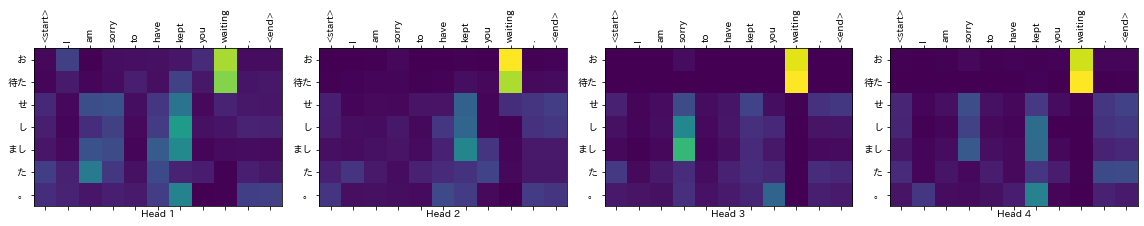

Input: The man you see over there is a famous writer .
Output: 向こうに見えるのが有名な作家です。


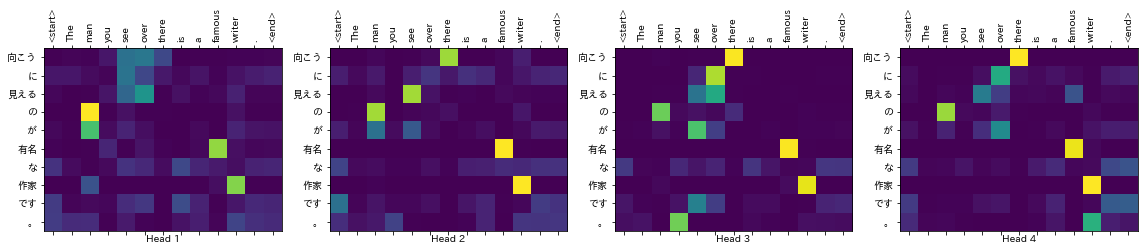

Input: Who wants to go ?
Output: 誰が行きたいですか。


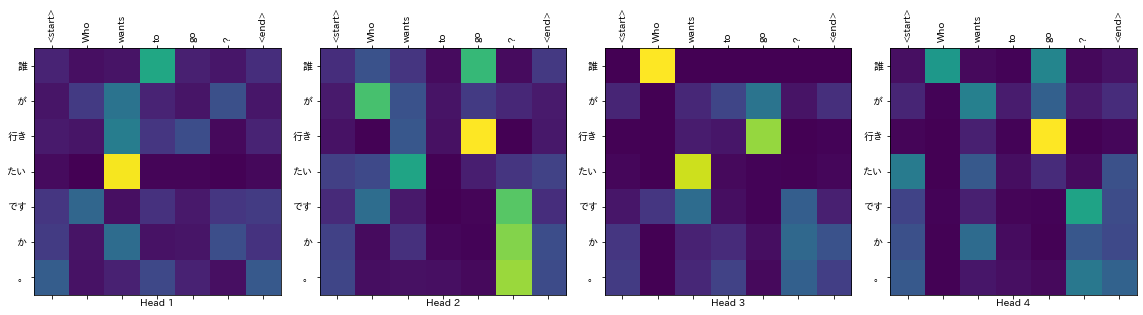

Input: My brother is engaged in cancer research .
Output: 兄はガンの研究に従事している。


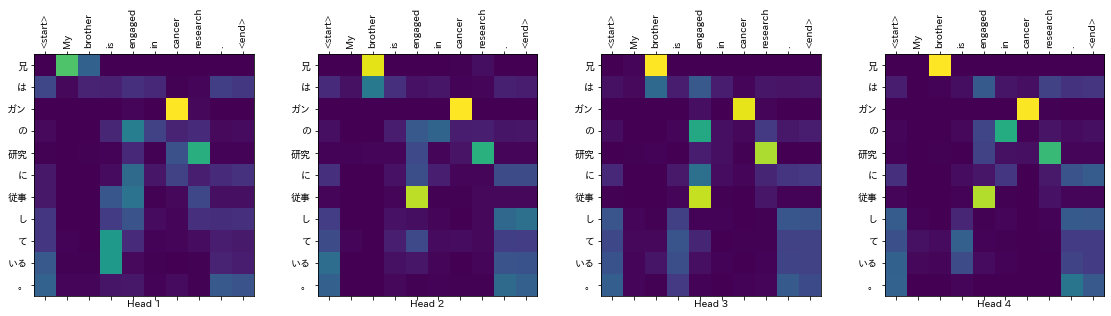

Input: He remained poor all his life .
Output: 彼は一生涯貧乏だった。


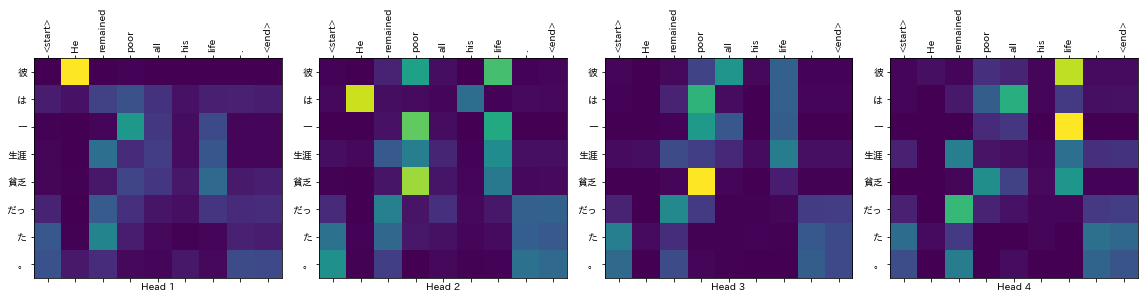

Input: Tom doesn ' t know French .
Output: トムはフランス語を知らない。


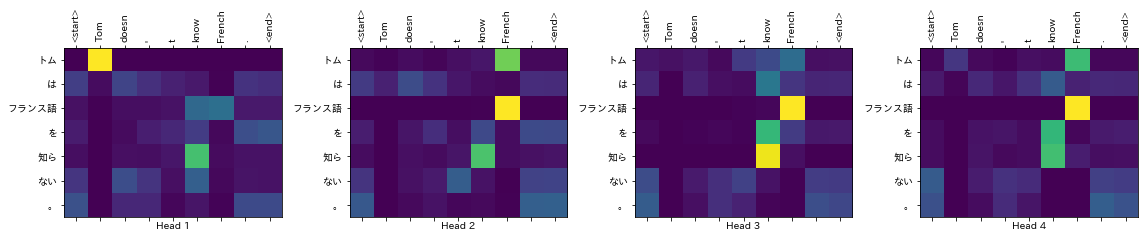

Input: There ' s nothing harder than a diamond .
Output: ダイヤモンドほど硬いものはない。


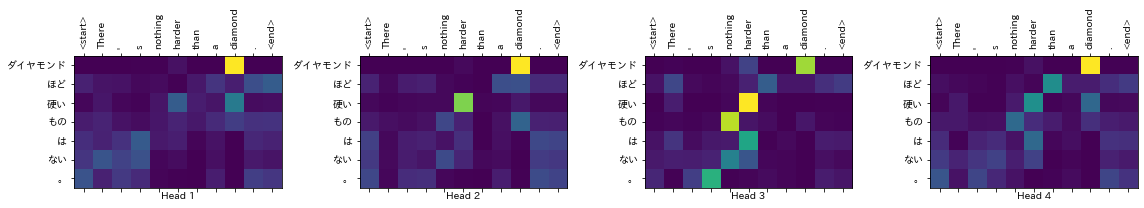

Input: That picture brought back a lot of memories .
Output: その写真はいろいろな思い出をよみがえらせた。


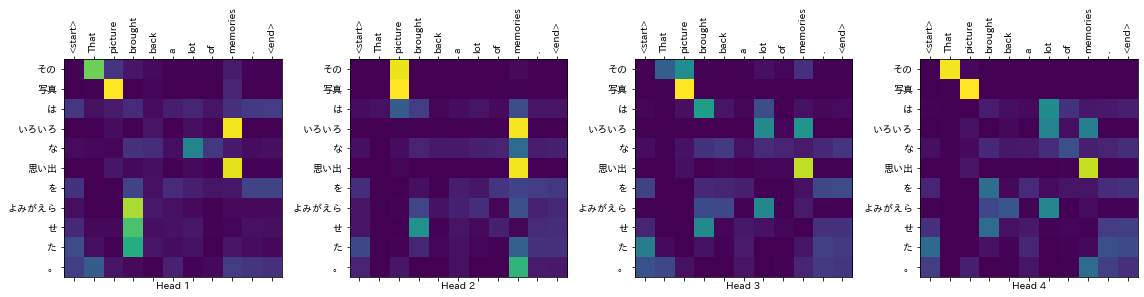

In [14]:
for i, (s, t, a) in enumerate(zip(inp.values, tar.values, attn['decoder_layer4_block2'].values)):
  sentence = tf.squeeze(s)[:tf.argmax(tf.squeeze(s)).numpy()+1]
  attention = a[0,:, :, :sentence.shape[0]]
  result = tf.squeeze(t)[:tf.argmax(tf.squeeze(t)).numpy()+1][1:]
  print("Input:", ' '.join([train_dataset.source_index[i.numpy()] for i in sentence][1:-1]))
  print("Output:", ''.join([train_dataset.target_index[i.numpy()] for i in result][:-1]))
  plot_attention_weight(sentence, attention, result)